In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd

In [5]:
class NeuralNetwork():

  def __init__(self):
    self.thetas = []
    self.activations = []
    self.gradients = []

  def initialize_network(self, layers):
    for i in range(1, len(layers)):
      # layer_weights = np.random.normal(0, 1, (layers[i], layers[i-1]))
      layer_weights = np.random.uniform(-1, 1, size= (layers[i], layers[i-1]))
      biases = np.random.random((layers[i], 1))
      self.thetas.append(np.hstack((biases, layer_weights)))

  def sigmoid(self, z):
    return 1 / (1 + np.exp(-z))

  def relu(self, z):
      return np.maximum(0, z)

  def forward(self, X):
    self.activations = []
    a = X
    a = np.vstack((np.array([1.0]), a))
    self.activations.append(a)
    counter = 1
    print("a{}: {}".format(counter,a))
    for i in range(0, len(self.thetas)-1):
      counter=counter+1
      z = np.dot(self.thetas[i], a)
      print("z{}: {}".format(counter,z))
      a = self.sigmoid(z)
      a = np.vstack((np.array([1.0]), a))
      print("a{}: {}".format(counter,a))
      self.activations.append(a)
    z = np.dot(self.thetas[len(self.thetas)-1], a)
    a = self.sigmoid(z)
    counter = counter+1
    print("z{}: {}".format(counter,z))
    print("a{}: {}".format(counter,a))

    self.activations.append(a)
    return a

  def backpropagation(self, X, Y, final_layer_activation):
      gradients = []
      error = final_layer_activation - Y
      deltas = [error]
      count = len(self.thetas)+1
      print("delta {}: {}".format(count, error))
      count = count-1

      for i in range(len(self.thetas) - 1, 0, -1):
          delta = np.dot(self.thetas[i][:,1:].T, deltas[-1]) * self.activations[i][1:] * (1 - self.activations[i][1:])
          print("delta {}: {}".format(count, delta))
          count=count-1
          deltas.append(delta)
      deltas = deltas[::-1]

      #  Computing gradients
      for i in range(len(self.thetas) - 1, -1, -1):
          gradient = np.dot(deltas[i], self.activations[i].T)
          gradients.append(gradient)

      if len(self.gradients) > 0:
        self.gradients = [arr1 + arr2 for arr1, arr2 in zip(self.gradients, gradients)]
      else:
        self.gradients = gradients
      return gradients

  def regularization(self, m, regularization=0.0):
      weights = self.thetas[::-1]
      for i in range(len(self.thetas) - 1, -1, -1):
          regularization_term = np.copy(weights[i])
          regularization_term[:, 0] = 0  # Exclude bias weights
          regularization_term *= regularization  # Regularization parameter
          self.gradients[i] = (1 / m) * (self.gradients[i] + regularization_term)
      return self.gradients

  def compute_cost(self, output, y):
      return -y * np.log(output) - (1 - y) * np.log(1-output)

  def update_weights(self, learning_rate ):
      gradients = self.gradients[::-1]
      for i in range(len(self.thetas) - 1, -1, -1):
        self.thetas[i] = self.thetas[i] - (learning_rate * gradients[i])

  def train(self, X, Y, learning_rate, epsilon=1e-6, max_epochs=1000, regularization=0.0):
      m = X.shape[0]  # Number of training examples
      epochs = 0
      prev_cost = np.inf

      while epochs < max_epochs:
          cost = 0
          for x, y in zip(X, Y):
              x = x.reshape(-1, 1)  # Reshape input to a column vector
              y = y.reshape(-1, 1)  # Reshape label to a column vector
              # Forward propagation
              final_activations = self.forward(x)
              cost += np.sum(self.compute_cost(final_activations, y))
              # Backpropagation
              # self.gradients = []  # Zero out gradients before backprop for each instance
              self.backpropagation(x, y, final_activations)
          cost /= m
          print(f"Epoch - {epochs} ----> Cost : {cost}")
          # Check stopping condition
          cost_diff = abs(cost - prev_cost)
          if cost_diff < epsilon:
              print(f"Converged after {epochs} epochs with cost {cost:.6f}")
              break

          self.regularization(m, regularization)
          self.update_weights(learning_rate)
          prev_cost = cost
          epochs += 1

      if epochs == max_epochs:
          print(f"Maximum number of epochs ({max_epochs}) reached with cost {cost:.6f}")

      return cost


  def split_data(self, X, y, k):
      classes, counts = np.unique(y, return_counts=True)
      train_test_sets = []
      for i in range(k):
          test_class_indices = np.array([])
          for class_label, count in zip(classes, counts):
              class_count = int(count * (1 / k))
              test_class_indices = np.concatenate((test_class_indices, np.array(np.where(y == class_label)[0][i * class_count:(i + 1) * class_count])))
          train_class_indices = np.array(X.index.difference(test_class_indices))
          X_train = X.iloc[train_class_indices]
          y_train = y.iloc[train_class_indices]
          X_test = X.iloc[test_class_indices]
          y_test = y.iloc[test_class_indices]
          train_test_sets.append((X_train, y_train, X_test, y_test))
      return train_test_sets

def normalize_features(min_vals, max_vals, data_x):
  if min_vals is None or max_vals is None:
      min_vals = np.min(data_x, axis=0)
      max_vals = np.max(data_x, axis=0)
  normalized_data = (data_x - min_vals) / (max_vals - min_vals)
  return normalized_data, min_vals, max_vals


def prepare_data(data, label_column_name):
      X = data.sample(frac=1).reset_index(drop=True)
      y = pd.DataFrame(X[label_column_name], index=X.index)
      X = X.drop(label_column_name, axis=1)
      return X, y

def vectorize_output(y, n_classes, start_of_class = 1):
    vectorized_output = np.zeros(n_classes)
    if start_of_class == 0:
        vectorized_output[y] = 1
    else:
        vectorized_output[y-1] = 1
    return vectorized_output


# Backprop_example1

In [64]:
nn = NeuralNetwork()
X = np.array([[[0.13]],[[0.42]]])
Y = np.array([[[0.9]],[[0.23]]])

nn.initialize_network([X[0].shape[0], 2, 1])

nn.thetas = [np.array([[0.4, 0.1], [0.3, 0.2]]), np.array([[0.7, 0.5, 0.6]])]

i=0
for x,y in zip(X,Y):
    i = i+1
    print("X is: ",x)
    print("Y is: ",y)
    final_output = nn.forward(x)
    cost_J = nn.compute_cost(final_output,y )
    print("Predicted output for instance:",final_output )
    print("Expected output for instance:",y)
    print("Cost, J, associated with instance: ", cost_J)
    print("Running backpropagation:\n")
    gradients = nn.backpropagation(x, y, final_output)
    count = len(gradients)
    for grad in gradients:
      print("Gradients of Theta{} based on training instance".format(count))
      count = count-1
      for row in grad:
        print("\t\t", end="")
        for val in row:
            print("{}".format(val), end="  ")
        print()
gradients = nn.regularization(2, 0.0)
print("The entire training set has been processes. Computing the average (regularized) gradients:\n")
count = len(gradients)
for grad in gradients:
      print("Final regularized gradients of Theta{}".format(count))
      count=count-1
      for row in grad:
        print("\t\t", end="")
        for val in row:
            print("{}".format(val), end="  ")
        print()

X is:  [[0.13]]
Y is:  [[0.9]]
a1: [[1.  ]
 [0.13]]
z2: [[0.413]
 [0.326]]
a2: [[1.       ]
 [0.601807 ]
 [0.5807858]]
z3: [[1.34937498]]
a3: [[0.79402743]]
Predicted output for instance: [[0.79402743]]
Expected output for instance: [[0.9]]
Cost, J, associated with instance:  [[0.36557477]]
Running backpropagation:

delta 3: [[-0.10597257]]
delta 2: [[-0.01269739]
 [-0.01548092]]
Gradients of Theta2 based on training instance
		-0.10597257356814194  -0.06377503699957358  -0.06154736571923857  
Gradients of Theta1 based on training instance
		-0.012697386528132475  -0.0016506602486572217  
		-0.015480917878463016  -0.0020125193242001922  
X is:  [[0.42]]
Y is:  [[0.23]]
a1: [[1.  ]
 [0.42]]
z2: [[0.442]
 [0.384]]
a2: [[1.        ]
 [0.60873549]
 [0.59483749]]
z3: [[1.36127024]]
a3: [[0.79596607]]
Predicted output for instance: [[0.79596607]]
Expected output for instance: [[0.23]]
Cost, J, associated with instance:  [[1.27637681]]
Running backpropagation:

delta 3: [[0.56596607]]
delta 2

# Backprop_example2

In [65]:
# 2nd verification file
nn = NeuralNetwork()
# Define the training instances
training_instance_1_x = np.array([[0.32], [0.68]])
training_instance_1_y = np.array([[0.75],[ 0.98]])

training_instance_2_x = np.array([[0.83], [0.02]])
training_instance_2_y = np.array([[0.75], [0.28]])

# Combine them into X and Y arrays
X = np.array([training_instance_1_x, training_instance_2_x])
Y = np.array([training_instance_1_y, training_instance_2_y])

nn.initialize_network([2, 4,3, 2])

nn.thetas = [np.array([[0.42, 0.15,0.4], [0.72, 0.1,0.54], [0.01,0.19, 0.42], [0.3,0.35,0.68]]),
    np.array([[0.21, 0.67, 0.14, 0.96, 0.87], [0.87, 0.42, 0.20, 0.32, 0.89],[0.03,0.56,0.80,0.69,0.09]]),
             np.array([[0.04,0.87,0.42,0.53], [0.17,0.1,0.95,0.69]])]
i=0
for x,y in zip(X,Y):
    i=i+1
    print("X is: ",x)
    print("Y is: ",y)
    final_output = nn.forward(x)
    cost_J = nn.compute_cost(final_output,y )
    print("Predicted output for instance:",final_output)
    print("Expected output for instance:",y )
    print("Cost, J, associated with instance: ", cost_J)
    gradients = nn.backpropagation(x, y, final_output)
gradients = nn.regularization(2, 0.25)
print("The entire training set has been processes. Computing the average (regularized) gradients:\n")
count = len(gradients)
for grad in gradients:
      print("Final regularized gradients of Theta{}".format(count))
      count=count-1
      for row in grad:
        print("\t\t", end="")
        for val in row:
            print("{}".format(val), end="  ")
        print()

X is:  [[0.32]
 [0.68]]
Y is:  [[0.75]
 [0.98]]
a1: [[1.  ]
 [0.32]
 [0.68]]
z2: [[0.74  ]
 [1.1192]
 [0.3564]
 [0.8744]]
a2: [[1.        ]
 [0.67699586]
 [0.75384029]
 [0.5881687 ]
 [0.70566042]]
z3: [[1.94769138]
 [2.12135808]
 [1.48153575]]
a3: [[1.        ]
 [0.87519469]
 [0.89296181]
 [0.81480444]]
z4: [[1.60830969]
 [1.66804824]]
a4: [[0.83317658]
 [0.84131543]]
Predicted output for instance: [[0.83317658]
 [0.84131543]]
Expected output for instance: [[0.75]
 [0.98]]
Cost, J, associated with instance:  [[0.5845871 ]
 [0.20614959]]
delta 4: [[ 0.08317658]
 [-0.13868457]]
delta 3: [[ 0.00638937]
 [-0.00925379]
 [-0.00778767]]
delta 2: [[-0.00086743]
 [-0.00133354]
 [-0.00053312]
 [-0.00070163]]
X is:  [[0.83]
 [0.02]]
Y is:  [[0.75]
 [0.28]]
a1: [[1.  ]
 [0.83]
 [0.02]]
z2: [[0.5525]
 [0.8138]
 [0.1761]
 [0.6041]]
a2: [[1.        ]
 [0.63471542]
 [0.69291867]
 [0.54391158]
 [0.64659376]]
z3: [[1.81695963]
 [2.02468436]
 [1.373268  ]]
a3: [[1.        ]
 [0.86020091]
 [0.88336451]
 [

# Wine Dataset

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Load the Wine dataset
wine_data = pd.read_csv("/content/drive/MyDrive/hw4/datasets/hw3_wine.csv", sep = '\t')

X, y = prepare_data(wine_data, '# class')
train_test_sets = nn.split_data(X, y, 10)

metrics = {'accuracy':[],'f1':[]}
fold_counter = 0

for X_train, y_train, X_test, y_test in train_test_sets:
    fold_counter = fold_counter + 1
    print("Training fold: ",fold_counter)
    nn = NeuralNetwork()
    nn.initialize_network([13, 4, 3])
    vectorized_y = []
    n_classes = 3
    for idx in range(len(y_train.values)):
      vectorized_y.append(vectorize_output(y_train.values[idx][0], n_classes))
    y_train = pd.DataFrame(vectorized_y)

    X_train, min_vals, max_vals = normalize_features(None, None, data_x = X_train)
    X_test, _, _ = normalize_features(min_vals, max_vals, data_x = X_test)

    J = nn.train(X_train.values, y_train.values, learning_rate=0.6, max_epochs=160, regularization = 0.0)

    # Predict on the test set
    y_pred = []
    for x in X_test.values:
        x = x.reshape(-1, 1)
        output_probs = nn.forward(x)
        predicted_class = np.argmax(output_probs) + 1
        y_pred.append(predicted_class)
    print(y_pred)
    y_pred = np.array(y_pred)
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test.values, y_pred)
    f1 = f1_score(y_test.values, y_pred, average='macro')

    # Append to metrics
    metrics['accuracy'].append(accuracy)
    metrics['f1'].append(f1)
# Calculate average accuracy and F1 score across folds
avg_accuracy = np.mean(metrics['accuracy'])
avg_f1 = np.mean(metrics['f1'])

print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1)

Training fold:  1
Epoch - 0 ----> Cost : 2.417739871745918
Epoch - 1 ----> Cost : 2.0716148207254332
Epoch - 2 ----> Cost : 1.9321512904459384
Epoch - 3 ----> Cost : 1.879646232781406
Epoch - 4 ----> Cost : 1.857312106466368
Epoch - 5 ----> Cost : 1.845645489682642
Epoch - 6 ----> Cost : 1.8379437265272265
Epoch - 7 ----> Cost : 1.8317502793956097
Epoch - 8 ----> Cost : 1.8261098837438183
Epoch - 9 ----> Cost : 1.8206331495965753
Epoch - 10 ----> Cost : 1.815154470943937
Epoch - 11 ----> Cost : 1.8095997975705538
Epoch - 12 ----> Cost : 1.803933474704049
Epoch - 13 ----> Cost : 1.7981362921409147
Epoch - 14 ----> Cost : 1.7921962635568713
Epoch - 15 ----> Cost : 1.7861047170953264
Epoch - 16 ----> Cost : 1.7798546360753882
Epoch - 17 ----> Cost : 1.7734399627875685
Epoch - 18 ----> Cost : 1.7668553173771329
Epoch - 19 ----> Cost : 1.7600958964860753
Epoch - 20 ----> Cost : 1.7531574499383187
Epoch - 21 ----> Cost : 1.7460362911742513
Epoch - 22 ----> Cost : 1.7387293218632658
Epoch - 2

X in prep data:  <class 'float'>
X in prep data after drop:  <class 'float'>
Epoch - 0 ----> Cost : 1.9746607441980806
Epoch - 1 ----> Cost : 1.691824642529943
Epoch - 2 ----> Cost : 1.5231918901129977
Epoch - 3 ----> Cost : 1.4363955580175407
Epoch - 4 ----> Cost : 1.3853349230416607
Epoch - 5 ----> Cost : 1.3496331263163805
Epoch - 6 ----> Cost : 1.321115151749063
Epoch - 7 ----> Cost : 1.2962945998841866
Epoch - 8 ----> Cost : 1.2734804620547702
Epoch - 9 ----> Cost : 1.2517332096373213
Epoch - 10 ----> Cost : 1.2304749038704206
Epoch - 11 ----> Cost : 1.209327859085359
Epoch - 12 ----> Cost : 1.1880391029292812
Epoch - 13 ----> Cost : 1.1664408048343256
Epoch - 14 ----> Cost : 1.1444272776655275
Epoch - 15 ----> Cost : 1.1219401153990733
Epoch - 16 ----> Cost : 1.0989575464191372
Epoch - 17 ----> Cost : 1.0754861526632644
Epoch - 18 ----> Cost : 1.0515541046698933
Epoch - 19 ----> Cost : 1.027205541228928
Epoch - 20 ----> Cost : 1.0024959317851638
Epoch - 21 ----> Cost : 0.97748833

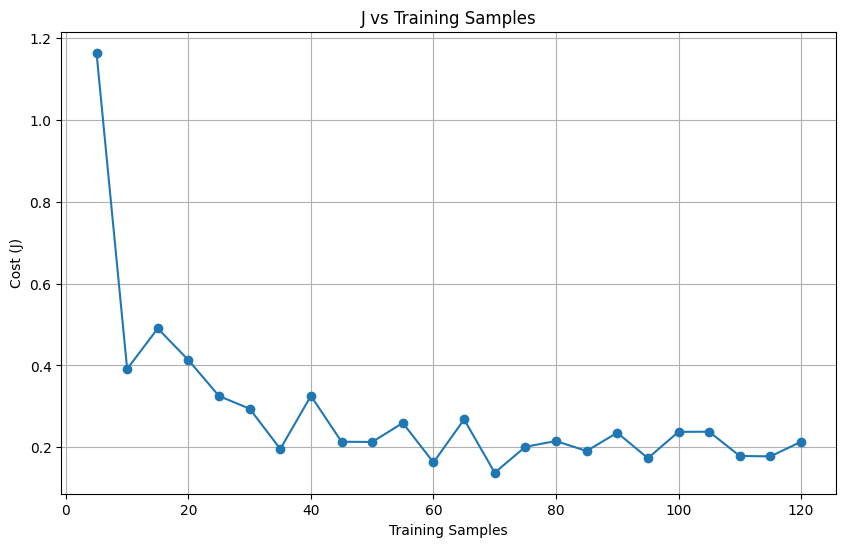

In [50]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def train_incremental_samples(nn, A, b, initial_size=5, increment=5, learning_rate=0.6, max_epochs=160, regularization=0.0, test_size=0.3, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=test_size, random_state=random_state)
    train_size = initial_size
    cost_history = []  # Store cost values for each training iteration
    while train_size <= len(X_train):
        nn = NeuralNetwork()
        nn.initialize_network([13, 4, 3])
        vectorized_y = []
        n_classes = 3
        for idx in range(len(y_train.values)):
          vectorized_y.append(vectorize_output(y_train.values[idx][0], n_classes))
        encoded_y_train = pd.DataFrame(vectorized_y)

        X_train, min_vals, max_vals = normalize_features(None, None, data_x = X_train)
        X_test, _, _ = normalize_features(min_vals, max_vals, data_x = X_test)

        cost = nn.train(X_train[:train_size].values, encoded_y_train[:train_size].values, learning_rate=learning_rate, max_epochs=max_epochs, regularization=regularization)
        vectorized_y = []
        n_classes = 3
        for idx in range(len(y_test.values)):
          vectorized_y.append(vectorize_output(y_test.values[idx][0], n_classes))
        encoded_y_test = pd.DataFrame(vectorized_y)

        cost = 0
        for index in range(len(X_test.to_numpy())):
          p = X_test.to_numpy()[index].reshape(-1, 1)  # Reshape input to a column vector
          q = encoded_y_test.to_numpy()[index].reshape(-1, 1)  # Reshape label to a column vector
          # Forward propagation
          final_activations = nn.forward(p)
          cost += np.sum(nn.compute_cost(final_activations, q))
        m = X.shape[0]
        cost=cost/m

        cost_history.append(cost)
        train_size += increment
    return X_train,cost_history


wine_data_2 = pd.read_csv("/content/drive/MyDrive/hw4/datasets/hw3_wine.csv", sep = '\t')
A, b = prepare_data(wine_data_2, '# class')
X_train, cost_history = train_incremental_samples(nn=nn, A=A, b=b)
samples = range(5, len(X_train) + 1, 5)

plt.figure(figsize=(10, 6))
plt.plot(samples, cost_history, marker='o')
plt.title('J vs Training Samples')
plt.xlabel('Training Samples')
plt.ylabel('Cost (J)')
plt.grid(True)
plt.show()

# Voting Dataset

In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Load the Voting dataset
voting_data = pd.read_csv("/content/drive/MyDrive/hw4/datasets/hw3_house_votes_84.csv")

X, y = prepare_data(voting_data, 'class')
nn = NeuralNetwork()
train_test_sets = nn.split_data(X, y, 10)

metrics = {'accuracy':[],'f1':[]}
fold_counter = 0

for X_train, y_train, X_test, y_test in train_test_sets:
    fold_counter = fold_counter + 1
    print("Training fold: ",fold_counter)
    nn = NeuralNetwork()
    nn.initialize_network([16, 4, 2])
    vectorized_y = []
    n_classes = 2
    for idx in range(len(y_train.values)):
        vectorized_y.append(vectorize_output(y_train.values[idx][0], n_classes, 0))
    y_train = pd.DataFrame(vectorized_y)

    J = nn.train(X_train.values, y_train.values, learning_rate=0.5, max_epochs=500, regularization = 0.0)

    # Predict on the test set
    y_pred = []
    for x in X_test.values:
        x = x.reshape(-1, 1)
        output_probs = nn.forward(x)
        predicted_class = np.argmax(output_probs)
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test.values, y_pred)
    f1 = f1_score(y_test.values, y_pred, average='macro')

    # Append to metrics
    metrics['accuracy'].append(accuracy)
    metrics['f1'].append(f1)

    print("Accuracy for fold {} : {}".format(fold_counter, accuracy))
    print("F1 for fold {} : {}".format(fold_counter, f1))

# Calculate average accuracy and F1 score across folds
avg_accuracy = np.mean(metrics['accuracy'])
avg_f1 = np.mean(metrics['f1'])

print("\nAverage Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1)

Streaming output truncated to the last 5000 lines.
Epoch - 42 ----> Cost : 0.9356140507259051
Epoch - 43 ----> Cost : 0.9239758267556543
Epoch - 44 ----> Cost : 0.912573702762704
Epoch - 45 ----> Cost : 0.9014067460643255
Epoch - 46 ----> Cost : 0.8904730103820269
Epoch - 47 ----> Cost : 0.8797697377669323
Epoch - 48 ----> Cost : 0.8692935337185578
Epoch - 49 ----> Cost : 0.8590405183845459
Epoch - 50 ----> Cost : 0.8490064565342298
Epoch - 51 ----> Cost : 0.839186868676339
Epoch - 52 ----> Cost : 0.8295771252880246
Epoch - 53 ----> Cost : 0.820172525683622
Epoch - 54 ----> Cost : 0.8109683626234833
Epoch - 55 ----> Cost : 0.8019599733947365
Epoch - 56 ----> Cost : 0.7931427778357635
Epoch - 57 ----> Cost : 0.7845123036675677
Epoch - 58 ----> Cost : 0.7760641995656343
Epoch - 59 ----> Cost : 0.7677942366592433
Epoch - 60 ----> Cost : 0.7596982995535776
Epoch - 61 ----> Cost : 0.7517723684729053
Epoch - 62 ----> Cost : 0.7440124946335135
Epoch - 63 ----> Cost : 0.7364147713741469
Epoch 

Streaming output truncated to the last 5000 lines.
Epoch - 10 ----> Cost : 1.2881301674331593
Epoch - 11 ----> Cost : 1.2829936787826624
Epoch - 12 ----> Cost : 1.2779054129965184
Epoch - 13 ----> Cost : 1.2727544766593422
Epoch - 14 ----> Cost : 1.2674795638401686
Epoch - 15 ----> Cost : 1.2620459185698605
Epoch - 16 ----> Cost : 1.2564331795287096
Epoch - 17 ----> Cost : 1.2506289515963578
Epoch - 18 ----> Cost : 1.2446254023542473
Epoch - 19 ----> Cost : 1.2384174657951046
Epoch - 20 ----> Cost : 1.232001905757079
Epoch - 21 ----> Cost : 1.2253768414403605
Epoch - 22 ----> Cost : 1.2185415205198322
Epoch - 23 ----> Cost : 1.2114962220073506
Epoch - 24 ----> Cost : 1.2042422227902478
Epoch - 25 ----> Cost : 1.1967817902193196
Epoch - 26 ----> Cost : 1.189118179322458
Epoch - 27 ----> Cost : 1.181255622850591
Epoch - 28 ----> Cost : 1.173199308320176
Epoch - 29 ----> Cost : 1.1649553399967632
Epoch - 30 ----> Cost : 1.1565306861644096
Epoch - 31 ----> Cost : 1.147933113497641
Epoch - 

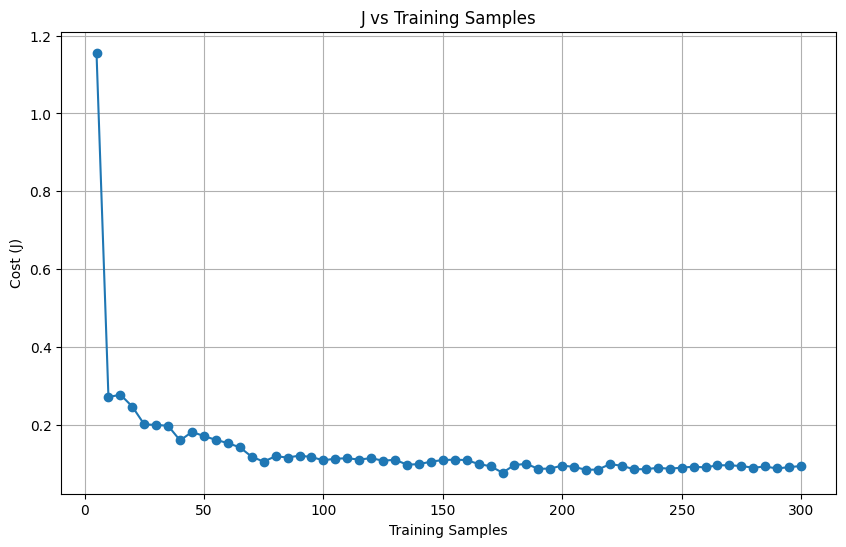

In [13]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def train_incremental_samples(nn, A, b, initial_size=5, increment=5, learning_rate=0.5, max_epochs=500, regularization=0.0, test_size=0.3, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=test_size, random_state=random_state)
    train_size = initial_size
    cost_history = []  # Store cost values for each training iteration
    while train_size <= len(X_train):
        nn = NeuralNetwork()
        nn.initialize_network([16, 4, 2])
        vectorized_y = []
        n_classes = 2
        for idx in range(len(y_train.values)):
          vectorized_y.append(vectorize_output(y_train.values[idx][0], n_classes,0))
        encoded_y_train = pd.DataFrame(vectorized_y)

        X_train, min_vals, max_vals = normalize_features(None, None, data_x = X_train)
        X_test, _, _ = normalize_features(min_vals, max_vals, data_x = X_test)

        cost = nn.train(X_train[:train_size].values, encoded_y_train[:train_size].values, learning_rate=learning_rate, max_epochs=max_epochs, regularization=regularization)
        vectorized_y = []
        for idx in range(len(y_test.values)):
          vectorized_y.append(vectorize_output(y_test.values[idx][0], n_classes,0))
        encoded_y_test = pd.DataFrame(vectorized_y)

        cost = 0
        for index in range(len(X_test.to_numpy())):
          p = X_test.to_numpy()[index].reshape(-1, 1)  # Reshape input to a column vector
          q = encoded_y_test.to_numpy()[index].reshape(-1, 1)  # Reshape label to a column vector
          # Forward propagation
          final_activations = nn.forward(p)
          cost += np.sum(nn.compute_cost(final_activations, q))
        m = X.shape[0]
        cost=cost/m

        cost_history.append(cost)
        train_size += increment
    return X_train,cost_history


voting_data_2 = pd.read_csv("/content/drive/MyDrive/hw4/datasets/hw3_house_votes_84.csv")
A, b = prepare_data(voting_data_2, 'class')
X_train, cost_history = train_incremental_samples(nn=nn, A=A, b=b)
samples = range(5, len(X_train) + 1, 5)

plt.figure(figsize=(10, 6))
plt.plot(samples, cost_history, marker='o')
plt.title('J vs Training Samples')
plt.xlabel('Training Samples')
plt.ylabel('Cost (J)')
plt.grid(True)
plt.show()

# Breast Cancer Dataset

In [20]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
# Load the Voting dataset
cancer_data = pd.read_csv("/content/drive/MyDrive/hw4/datasets/hw3_cancer.csv", sep = '\t')

X, y = prepare_data(cancer_data, 'Class')
train_test_sets = nn.split_data(X, y, 10)

metrics = {'accuracy':[],'f1':[]}
fold_counter = 0

for X_train, y_train, X_test, y_test in train_test_sets:
    fold_counter = fold_counter + 1
    print("Training fold: ",fold_counter)
    nn = NeuralNetwork()
    nn.initialize_network([9, 4, 3, 2])
    vectorized_y = []
    n_classes = 2
    for idx in range(len(y_train.values)):
      vectorized_y.append(vectorize_output(y_train.values[idx][0], n_classes, 0))
    y_train = pd.DataFrame(vectorized_y)

    X_train, min_vals, max_vals = normalize_features(None, None, data_x = X_train)
    X_test, _, _ = normalize_features(min_vals, max_vals, data_x = X_test)

    J = nn.train(X_train.values, y_train.values, learning_rate=0.5, max_epochs=160, regularization = 0.0)

    # Predict on the test set
    y_pred = []
    for x in X_test.values:
        x = x.reshape(-1, 1)
        output_probs = nn.forward(x)
        predicted_class = np.argmax(output_probs)
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test.values, y_pred)
    f1 = f1_score(y_test.values, y_pred, average='macro')

    # Append to metrics
    metrics['accuracy'].append(accuracy)
    metrics['f1'].append(f1)
# Calculate average accuracy and F1 score across folds
avg_accuracy = np.mean(metrics['accuracy'])
avg_f1 = np.mean(metrics['f1'])

print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1)

Training fold:  1
Epoch - 0 ----> Cost : 1.3968965396584925
Epoch - 1 ----> Cost : 1.354029789782845
Epoch - 2 ----> Cost : 1.3287366887003789
Epoch - 3 ----> Cost : 1.3134424372300564
Epoch - 4 ----> Cost : 1.3039146095402545
Epoch - 5 ----> Cost : 1.29778441918821
Epoch - 6 ----> Cost : 1.2936940636428174
Epoch - 7 ----> Cost : 1.290847104812257
Epoch - 8 ----> Cost : 1.2887668173680864
Epoch - 9 ----> Cost : 1.287162887730504
Epoch - 10 ----> Cost : 1.285855925211016
Epoch - 11 ----> Cost : 1.2847336764873334
Epoch - 12 ----> Cost : 1.2837250952713835
Epoch - 13 ----> Cost : 1.2827847137034132
Epoch - 14 ----> Cost : 1.2818830839168243
Epoch - 15 ----> Cost : 1.2810008611453119
Epoch - 16 ----> Cost : 1.2801251045635065
Epoch - 17 ----> Cost : 1.279246945730602
Epoch - 18 ----> Cost : 1.2783601091043284
Epoch - 19 ----> Cost : 1.2774599679044654
Epoch - 20 ----> Cost : 1.2765429386310332
Epoch - 21 ----> Cost : 1.2756060909877491
Epoch - 22 ----> Cost : 1.2746468954155836
Epoch - 23

Epoch - 0 ----> Cost : 2.0682538200026164
Epoch - 1 ----> Cost : 1.7276683796540055
Epoch - 2 ----> Cost : 1.4864985280314484
Epoch - 3 ----> Cost : 1.377330171827285
Epoch - 4 ----> Cost : 1.3359346399626701
Epoch - 5 ----> Cost : 1.318583898053197
Epoch - 6 ----> Cost : 1.3081592485559763
Epoch - 7 ----> Cost : 1.2992839944861516
Epoch - 8 ----> Cost : 1.2903900929161805
Epoch - 9 ----> Cost : 1.2809943304909657
Epoch - 10 ----> Cost : 1.2709052408060433
Epoch - 11 ----> Cost : 1.2600097342583143
Epoch - 12 ----> Cost : 1.2482189303570892
Epoch - 13 ----> Cost : 1.2354560071130172
Epoch - 14 ----> Cost : 1.2216550339575203
Epoch - 15 ----> Cost : 1.206762692033005
Epoch - 16 ----> Cost : 1.1907406690251017
Epoch - 17 ----> Cost : 1.1735679803661831
Epoch - 18 ----> Cost : 1.155242828063934
Epoch - 19 ----> Cost : 1.1357837177932493
Epoch - 20 ----> Cost : 1.1152296348900665
Epoch - 21 ----> Cost : 1.0936391829319774
Epoch - 22 ----> Cost : 1.0710887153223778
Epoch - 23 ----> Cost : 1

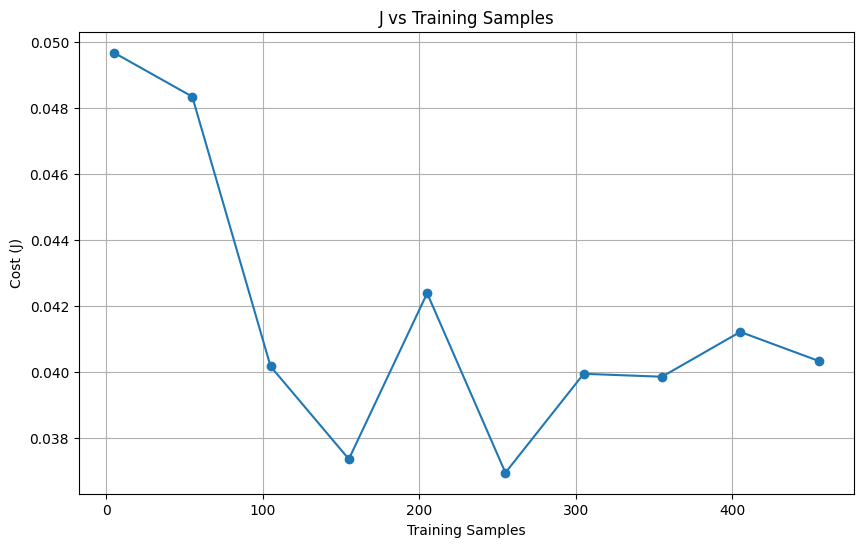

In [26]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def train_incremental_samples(nn, A, b, initial_size=5, increment=50, learning_rate=0.5, max_epochs=200, regularization=0.0, test_size=0.3, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(A, b, test_size=test_size, random_state=random_state)
    train_size = initial_size
    cost_history = []  # Store cost values for each training iteration
    while train_size <= len(X_train):
        nn = NeuralNetwork()
        nn.initialize_network([9, 4, 2])
        vectorized_y = []
        n_classes = 2
        for idx in range(len(y_train.values)):
          vectorized_y.append(vectorize_output(y_train.values[idx][0], n_classes,0))
        encoded_y_train = pd.DataFrame(vectorized_y)

        X_train, min_vals, max_vals = normalize_features(None, None, data_x = X_train)
        X_test, _, _ = normalize_features(min_vals, max_vals, data_x = X_test)

        cost = nn.train(X_train[:train_size].values, encoded_y_train[:train_size].values, learning_rate=learning_rate, max_epochs=max_epochs, regularization=regularization)
        vectorized_y = []
        for idx in range(len(y_test.values)):
          vectorized_y.append(vectorize_output(y_test.values[idx][0], n_classes,0))
        encoded_y_test = pd.DataFrame(vectorized_y)

        cost = 0
        for index in range(len(X_test.to_numpy())):
          p = X_test.to_numpy()[index].reshape(-1, 1)  # Reshape input to a column vector
          q = encoded_y_test.to_numpy()[index].reshape(-1, 1)  # Reshape label to a column vector
          # Forward propagation
          final_activations = nn.forward(p)
          cost += np.sum(nn.compute_cost(final_activations, q))
        m = X.shape[0]
        cost=cost/m

        cost_history.append(cost)
        train_size += increment
    return X_train,cost_history


voting_data_2 = pd.read_csv("/content/drive/MyDrive/hw4/datasets/hw3_cancer.csv", sep = '\t')
A, b = prepare_data(voting_data_2, 'Class')
X_train, cost_history = train_incremental_samples(nn=nn, A=A, b=b)
samples = range(5, len(X_train) + 1, 50)

plt.figure(figsize=(10, 6))
plt.plot(samples, cost_history, marker='o')
plt.title('J vs Training Samples')
plt.xlabel('Training Samples')
plt.ylabel('Cost (J)')
plt.grid(True)
plt.show()

# CMC Dataset

In [21]:
!pip3 install ucimlrepo

In [40]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
contraceptive_method_choice = fetch_ucirepo(id=30)
X = contraceptive_method_choice.data.features
y = contraceptive_method_choice.data.targets

metadata = contraceptive_method_choice.variables
# Iterate through columns and convert to appropriate type
for col_name, col_type in zip(metadata['name'], metadata['type']):
    oneHotEncoder = {}
    oneHotEncoderCount = 0
    if col_name not in X.columns:
        continue
    if col_type == 'Integer':
        X[col_name] = X[col_name].astype(np.int64)
    else:
        for i in range(len(X[col_name].values)):
            if X[col_name][i] in oneHotEncoder.keys():
                X[col_name][i]= oneHotEncoder[ X[col_name][i]]
            else:
                oneHotEncoder[X[col_name][i]] = oneHotEncoderCount
                X[col_name][i] = oneHotEncoderCount
                oneHotEncoderCount = oneHotEncoderCount + 1
X["class"] = y
# Load the CMC dataset
X, y = prepare_data(X, 'class')

Streaming output truncated to the last 5000 lines.
<ipython-input-40-ca87db2ce185>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name][i]= oneHotEncoder[ X[col_name][i]]
<ipython-input-40-ca87db2ce185>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name][i]= oneHotEncoder[ X[col_name][i]]
<ipython-input-40-ca87db2ce185>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col_name][i]= oneHotEncoder[ X[col_name][i]]
<

In [31]:
X

,wife_age,wife_edu,husband_edu,num_children,wife_religion,wife_working,husband_occupation,standard_of_living_index,media_exposure,class
0,24,2,3,3,1,1,2,3,0,1
1,45,1,3,10,1,1,3,4,0,1
2,43,2,3,7,1,1,3,4,0,1
3,42,3,2,9,1,1,3,3,0,1
4,36,3,3,8,1,1,3,2,0,1
...,...,...,...,...,...,...,...,...,...,...
1468,33,4,4,2,1,0,2,4,0,3
1469,33,4,4,3,1,1,1,4,0,3
1470,39,3,3,8,1,0,1,4,0,3
1471,33,3,3,4,1,0,2,2,0,3


In [ ]:
train_test_sets = nn.split_data(X, y, 10)

metrics = {'accuracy':[],'f1':[]}
fold_counter = 0

for X_train, y_train, X_test, y_test in train_test_sets:
    fold_counter = fold_counter + 1
    print("Training fold: ",fold_counter)
    nn = NeuralNetwork()
    nn.initialize_network([9, 8,3])
    vectorized_y = []
    n_classes = 3
    for idx in range(len(y_train.values)):
      vectorized_y.append(vectorize_output(y_train.values[idx][0], n_classes))
    y_train = pd.DataFrame(vectorized_y)

    J = nn.train(X_train.values, y_train.values, learning_rate=0.01, max_epochs=200, regularization = 0)

    # Predict on the test set
    y_pred = []
    for x in X_test.values:
        x = x.reshape(-1, 1)
        output_probs = nn.forward(x)
        predicted_class = np.argmax(output_probs)
        y_pred.append(predicted_class)
    y_pred = np.array(y_pred)
    # Calculate accuracy and F1 score
    accuracy = accuracy_score(y_test.values, y_pred)
    f1 = f1_score(y_test.values, y_pred, average='macro')

    # Append to metrics
    metrics['accuracy'].append(accuracy)
    metrics['f1'].append(f1)
    print("Accuracy for fold {} : {}".format(fold_counter, accuracy))
    print("F1 for fold {} : {}".format(fold_counter, f1))
# Calculate average accuracy and F1 score across folds
avg_accuracy = np.mean(metrics['accuracy'])
avg_f1 = np.mean(metrics['f1'])

print("Average Accuracy:", avg_accuracy)
print("Average F1 Score:", avg_f1)

Training fold:  1
Epoch - 0 ----> Cost : 2.5777802791745636
Epoch - 1 ----> Cost : 2.5179825019948594
Epoch - 2 ----> Cost : 2.471726029729883
Epoch - 3 ----> Cost : 2.435150362275253
Epoch - 4 ----> Cost : 2.404420651537174
Epoch - 5 ----> Cost : 2.37737405889418
Epoch - 6 ----> Cost : 2.352862414774982
Epoch - 7 ----> Cost : 2.3302453915116446
Epoch - 8 ----> Cost : 2.30914019246193
Epoch - 9 ----> Cost : 2.2893018173793545
Epoch - 10 ----> Cost : 2.270563380832832
Epoch - 11 ----> Cost : 2.2528047093009174
Epoch - 12 ----> Cost : 2.235934929255864
Epoch - 13 ----> Cost : 2.2198823472365237
Epoch - 14 ----> Cost : 2.204588319070506
Epoch - 15 ----> Cost : 2.1900033981238707
Epoch - 16 ----> Cost : 2.17608483645808
Epoch - 17 ----> Cost : 2.1627949167156904
Epoch - 18 ----> Cost : 2.1500998095364054
Epoch - 19 ----> Cost : 2.1379687723218903
Epoch - 20 ----> Cost : 2.126373574983197
Epoch - 21 ----> Cost : 2.115288079823537
Epoch - 22 ----> Cost : 2.104687928084368
Epoch - 23 ----> Co